In [1]:
from resources.notebook_library import *
from resources.gate_simulation.ghz import ghz_simulation
from resources.gate_simulation.ghz import gate_simulation_functions
from resources.dataframe_lib import conditionally_append_result
GateSimulation  = ghz_simulation
sim = GateSimulation.Simulation('O-x-O',load_setup=True,load_analytical=True)

Loading O-x-O setup
Preparing Analytical sub-class
Preparing SuperoperatorBellPair sub-class

Done!


# Obtain grid(s) of performance

In [40]:
# Global Parameters 
kSweep = [0.9,0.95]   #[0.995]


SplitSweep =[5,10]#[10]#[5,10,15]#,10,15,20]# [5,10]
 

# Bounds of optimization
## DE will be multiplied by  np.sqrt(C_val)
DE_C_min = 1
DE_C_max = 20
C_c_min = 0.1
C_c_max = 10
tg_min = 0.7
tg_max = 1.2
rot_p_min = - np.pi/2 
rot_p_max = - rot_p_min
rot_i_min = - np.pi/2  
rot_i_max = -rot_i_min
rot_b_min = - np.pi/2 * 10**(-20)
rot_b_max = -rot_b_min

# Optimization settings
opt_settings_dict = {
"ghz_dim":2,                # 3-ghz state or 4-ghz state
'swap_into_memory':False,    # Use of nuclear memory  None corresponds to seeking for a maximum
'fidelity_cap': 0.995 , 'confidence_interval':0.99, #Cost function parameters
"n_cores": 16,  # Number of cores to use in optimization
"disp_bool" : True, "maxiter":100} # Show optimization progress

## Using analytical simulations

In [41]:
AllParams = [((ai,a),(bi,b)) for ai,a in enumerate(kSweep) for bi,b in enumerate(SplitSweep)] # Create a 2-d grid for hardware parameters

TotalParamElems = NumElemsInList(AllParams)


CurrentNumberOfSimulations = 1
Results = [ [{} for j in range(len(SplitSweep))] for i in range(len(kSweep))]
for  ((k_ind,k_val),(mx_spl_ind,mx_spl)) in AllParams:
    print(f'Optimizing {CurrentNumberOfSimulations} out of {TotalParamElems}')
    CurrentNumberOfSimulations +=1
    c_val = k_val/ (4-4*k_val)
    
    hardware_dict = {sg.var('c'): c_val,sg.var('k'):k_val  ,sg.var('D_max'): mx_spl}

    sim.Analytical.obtain_gate_performance_hardware(hardware_dict)
    bounds = [[C_c_min*c_val,C_c_max*c_val],[0 , mx_spl] , 
                [DE_C_min,DE_C_max ] , [tg_min,tg_max]  ]
    # Add rotation bounds depending on the ghz_dim
    #for i in range(opt_settings_dict["ghz_dim"]) : bounds.append([rot_min,rot_max]) 
    for i in range(opt_settings_dict["ghz_dim"]) : bounds.append([rot_p_min,rot_p_max]) 
    for i in range(opt_settings_dict["ghz_dim"]) : bounds.append([rot_i_min,rot_i_max]) 
    if opt_settings_dict["ghz_dim"] >2:
        bounds.append([rot_p_min,rot_p_max]) 
        bounds.append([rot_i_min,rot_i_max]) 
    
    sim.Analytical.optimize_gate_performance_hardware(bounds,opt_settings_dict)
    
    optimized_performance_dict = sim.Analytical.optimized_performance_dict
    opt_cost_function = gate_simulation_functions.gate_performance_cost_function(optimized_performance_dict,opt_settings_dict)

    tunable_params_dict = sim.Analytical.opt_tunable_dict
    
    result = {'hardware': hardware_dict , 
            'performance': optimized_performance_dict,
            'tuning': tunable_params_dict,
            'opt_settings' : opt_settings_dict, 
            'cost': opt_cost_function}

    Results[k_ind][mx_spl_ind] = result
    conditionally_append_result(result)
    gc.collect()  # clear unreferenced memory
    clear_output(wait=True)

Optimizing 4 out of 4
differential_evolution step 1: f(x)= 5.27924
differential_evolution step 2: f(x)= 1.07021
differential_evolution step 3: f(x)= 1.07021
differential_evolution step 4: f(x)= 1.07021
differential_evolution step 5: f(x)= 0.968208
differential_evolution step 6: f(x)= 0.968208
differential_evolution step 7: f(x)= 0.308506
differential_evolution step 8: f(x)= 0.308506
differential_evolution step 9: f(x)= -2.68463
differential_evolution step 10: f(x)= -2.68463
differential_evolution step 11: f(x)= -2.68463
differential_evolution step 12: f(x)= -2.68463
differential_evolution step 13: f(x)= -2.68463
differential_evolution step 14: f(x)= -4.51001
differential_evolution step 15: f(x)= -4.51001
differential_evolution step 16: f(x)= -4.51001
differential_evolution step 17: f(x)= -4.51001
differential_evolution step 18: f(x)= -4.51001
differential_evolution step 19: f(x)= -4.51001
differential_evolution step 20: f(x)= -7.54193
differential_evolution step 21: f(x)= -7.54193
diff

# Plot result

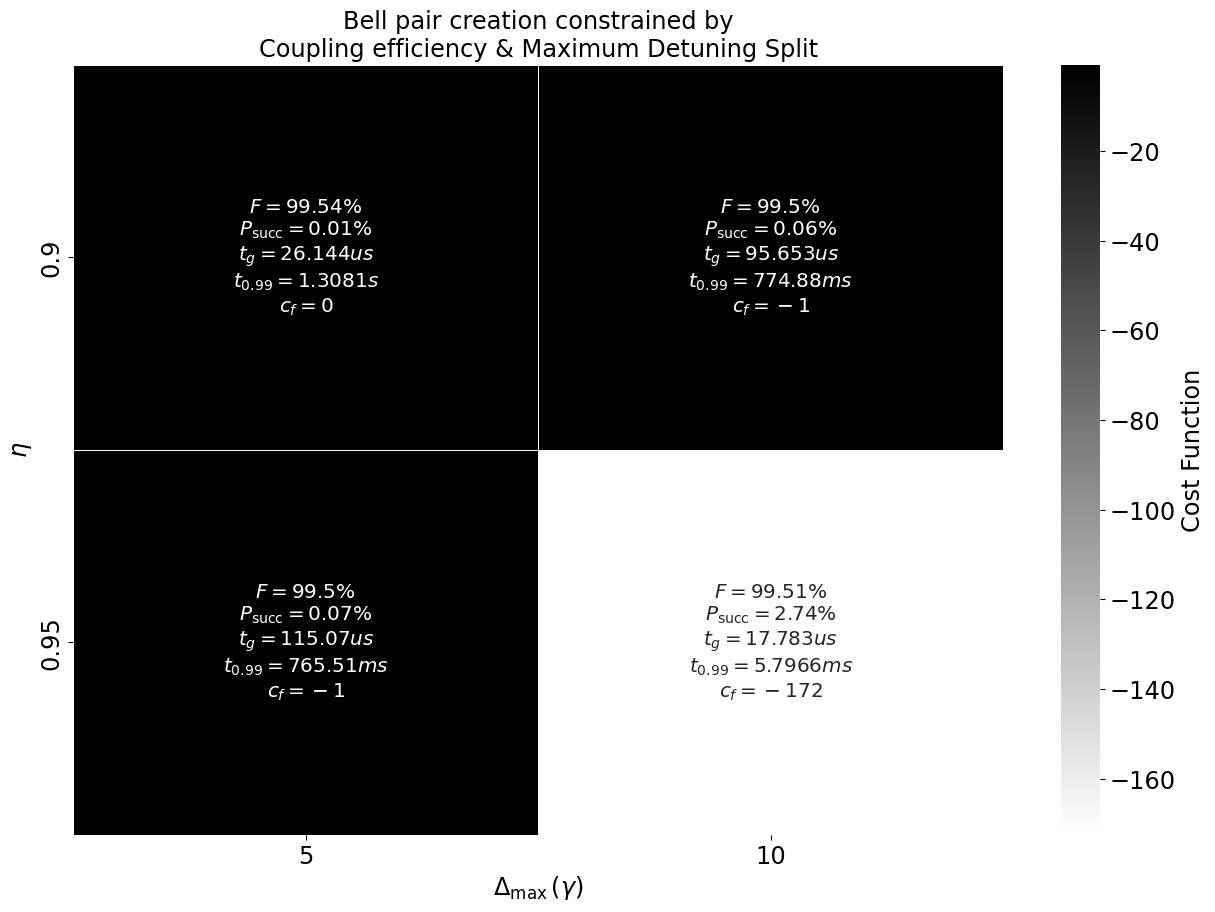

{'cost': -172.51582028864672,
 'hardware': {c: 4.749999999999996, k: 0.95, D_max: 10},
 'opt_settings': {'confidence_interval': 0.99,
                  'disp_bool': True,
                  'fidelity_cap': 0.995,
                  'ghz_dim': 2,
                  'maxiter': 100,
                  'n_cores': 16,
                  'swap_into_memory': False},
 'performance': {'concurrence': 0.9818675002677476,
                 'fidelity': 0.9951336428601644,
                 'gate_time': 533.4885244547348,
                 'p_success': 0.027429488251455275,
                 'swap_into_memory': False,
                 't_conf': 0.0057965698353162},
 'tuning': {C: 12.962743815203204,
            De: 2.416345634935806,
            DE_C: 1.0461610183243124,
            tgr: 0.8859048903847421,
            r0_p: -1.0398997351817676,
            r0_i: -0.6794746766743215,
            DE: 13.561117269990167,
            tgs: 533.4885244547348,
            rot: -2.51232371108488}}


In [42]:
plot_results(Results,plot_big=True)
costs = np.array([[Results[i][j]['cost'] for j in range(len(SplitSweep))]for i in range(len(kSweep))])
res_min = Results[ArgMin(costs)[0]][ArgMin(costs)[1]]
pprint(res_min)


# Print results

In [33]:

for i,C in enumerate(kSweep):
    for j,spl in enumerate(SplitSweep):
        #conditionally_append_result(Results[i][j])
        pass
        #print(Results[i][j]['tuning'][sg.var('DE')]/np.sqrt(C))
        #print(Results[i][j]['tuning'][sg.var('De')],spl)
        #print([Results[i][j]['tuning'][sg.var(f'r{k}_r')]  for k in range(opt_settings_dict["ghz_dim"] ) ])
       

# Superoperator

In [46]:


res_min["tuning"][sg.var('De0')] =  res_min["tuning"][sg.var('De')] - res_min["hardware"][sg.var('D_max')] 
res_min["tuning"][sg.var('r1_p')] =res_min["tuning"][sg.var('r0_p')]
res_min["tuning"][sg.var('r1_i')] =res_min["tuning"][sg.var('r0_i')]
tuning_dict = res_min["tuning"]
tuning_dict[sg.var('c')] = res_min['hardware'][sg.var('c')]
super_perf = sim.SuperoperatorBellPair.simulate(tuning_dict,gamma_g_is_zero=False)

In [47]:
super_perf

{'fidelity': 0.9950919408180842,
 'p_success': 0.02758863315283617,
 'gate_time': 533.4885244547346,
 'concurrence': 0.9817196187121289}

In [48]:
res_min["performance"]

{'gate_time': 533.4885244547348,
 'p_success': 0.027429488251455275,
 'fidelity': 0.9951336428601644,
 't_conf': 0.0057965698353162,
 'swap_into_memory': False,
 'concurrence': 0.9818675002677476}

# Load Best Results

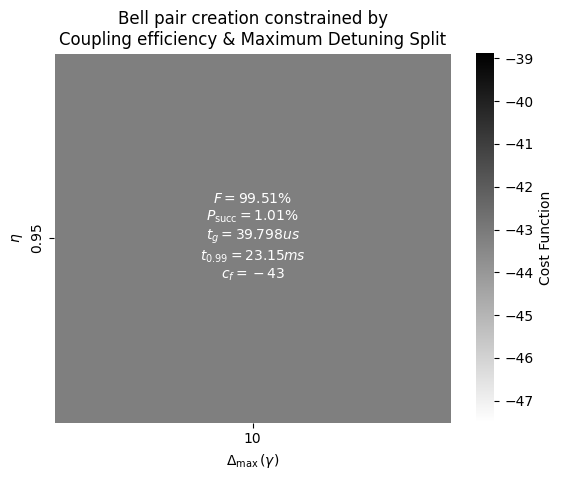

{'cost': -43.196357404617295,
 'hardware': {c: 4.749999999999996, k: 0.95, D_max: 10},
 'opt_settings': {'confidence_interval': 0.99,
                  'disp_bool': True,
                  'fidelity_cap': 0.995,
                  'ghz_dim': 2,
                  'maxiter': 100,
                  'n_cores': 16,
                  'swap_into_memory': False},
 'performance': {'concurrence': 0.9850376540628628,
                 'fidelity': 0.9950695879909917,
                 'gate_time': 1193.9535497294628,
                 'p_success': 0.0101451873244292,
                 'swap_into_memory': False,
                 't_conf': 0.0231501001492572},
 'tuning': {C: 8.539795194095884,
            De: 9.774636623567732,
            DE_C: 1.2858662023536116,
            tgr: 0.8911540145379021,
            r0_p: 0.3912407747723925,
            r0_i: 0.5139066767611761,
            DE: 10.981034015109698,
            tgs: 1193.9535497294628,
            rot: -0.2741893520406311}}


In [38]:
from resources.dataframe_lib import retrieve_result
best_results = [ [{} for j in range(len(SplitSweep))] for i in range(len(kSweep))]

ghz_dim = 2
for i,k in enumerate(kSweep):
    for j,spl in enumerate(SplitSweep):
        best_results[i][j] = retrieve_result(k,spl,ghz_dim)

plot_results(best_results,plot_big=False)
costs = np.array([[best_results[i][j]['cost'] for j in range(len(SplitSweep))]for i in range(len(kSweep))])
res_min = best_results[ArgMin(costs)[0]][ArgMin(costs)[1]]
pprint(res_min)
        